<a href="https://colab.research.google.com/github/korupalli/ML-Project/blob/master/Balencing2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# setting up default plotting parameters
%matplotlib inline

plt.rcParams['figure.figsize'] = [20.0, 7.0]
plt.rcParams.update({'font.size': 22,})

sns.set_palette('viridis')
sns.set_style('white')
sns.set_context('talk', font_scale=0.8)

In [3]:
frame = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data.csv')
frame.Mentions.replace(np.NaN,0,inplace=True)

frame.drop(frame.index[frame[frame['Retweets'] <= 10].index.values], inplace=True)
frame.reset_index(inplace=True)

#Dropping duplicated index columns
frame.drop(frame.columns[[0, 1]], axis = 1, inplace = True) 

frame['bin'] = pd.cut(frame['Retweets'], [10, 50, 100, 1000, 10000, 275530])

frame['bin'] = frame.bin.apply(preprocessing.LabelEncoder().fit_transform)

In [5]:
month_map={'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11 , 'Dec':12}
frame.Month = frame.Month.map(month_map)

day_map={'Mon':1, 'Tue':2, 'Wed':3, 'Thu':4, 'Fri':5, 'Sat':6, 'Sun':7}
frame.Day = frame.Day.map(day_map)

frame.Month = frame.Month.astype(np.object)
frame.Day = frame.Day.astype(np.object)
frame.Date = frame.Date.astype(np.object)
frame.Time = frame.Time.astype(np.object)
frame.Year = frame.Year.astype(np.object)

frame.Mentions.replace(np.NaN,0,inplace=True)
frame['Mentions_count'] = frame.Mentions.apply(lambda x:0 if x==0 else len(x.split()))

frame.Hashtags.replace(np.NaN,0,inplace=True)
frame['Hashtags_count'] = frame.Hashtags.apply(lambda x:0 if x==0 else len(x.split()))

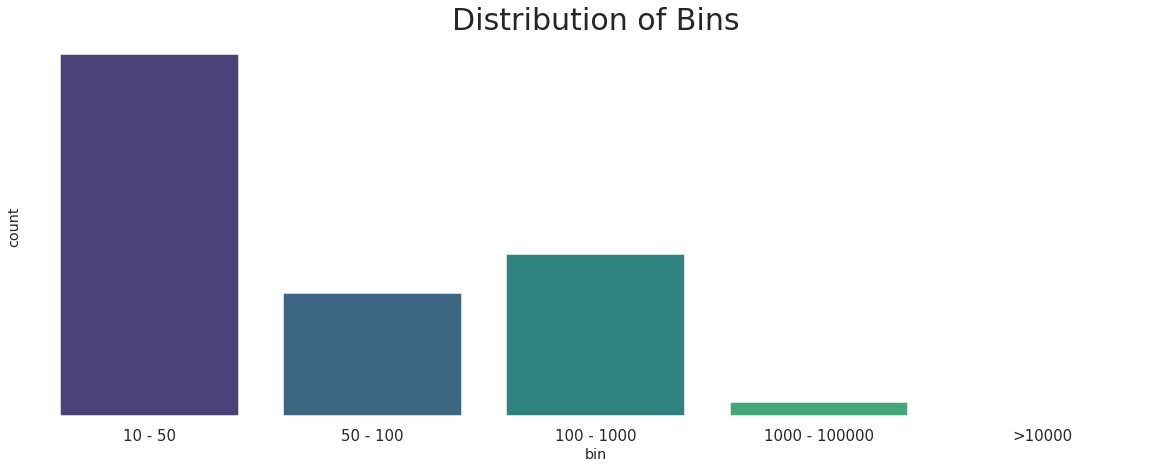

In [7]:
# using seaborns countplot to show distribution of questions in dataset
fig, ax = plt.subplots()
g = sns.countplot(frame.bin, palette='viridis')
g.set_xticklabels(['10 - 50', '50 - 100', '100 - 1000', '1000 - 100000', '>10000'])
g.set_yticklabels([])
sns.despine(left=True, bottom=True)
plt.title('Distribution of Bins', fontsize=30)
plt.tick_params(axis='x', which='major', labelsize=15)
plt.show()

In [8]:
y = frame.bin
X = frame.drop(['bin','Retweets', 'Mentions', 'Hashtags'], axis=1)

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=27)

In [ ]:
dummy = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)

# checking unique labels
print('Unique predicted labels: ', (np.unique(dummy_pred)))

# checking accuracy
print('Test score: ', accuracy_score(y_test, dummy_pred))

Unique predicted labels:  [0]
Test score:  0.5445148555994183


In [ ]:
print(f1_score(y_test, dummy_pred, average = 'macro'), recall_score(y_test, dummy_pred, average = 'macro'))

0.14101900117706406 0.2


In [ ]:
lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)
 
# Predict on training set
lr_pred = lr.predict(X_test)

accuracy_score(y_test, lr_pred)

In [ ]:
print(accuracy_score(y_test, lr_pred), f1_score(y_test, lr_pred, average = 'macro'), recall_score(y_test, lr_pred, average = 'macro'))

0.5445148555994183 0.14101900117706406 0.2


Trying with random_forest

In [ ]:
rfc = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)

# predict on test set
rfc_pred = rfc.predict(X_test)

print(accuracy_score(y_test, rfc_pred), f1_score(y_test, rfc_pred, average = 'macro'), recall_score(y_test, rfc_pred, average = 'macro'))

0.729586536463744 0.6044533687463565 0.5647948896729502


Reducing each class to 10% by maintaing the same ratios and reducing the overall size of dataset to its 10%

In [9]:
counts = y_train.value_counts().values

In [32]:
counts

array([1041385,  467109,  355305,   39763,    2323])

In [10]:
X = pd.concat([X_train, y_train], axis=1)

In [11]:
X_ = pd.concat([X[X['bin'] == 0].sample(int(0.1 * counts[0])), X[X['bin'] == 1].sample(int(0.1 * counts[1])), X[X['bin'] == 2].sample(int(0.1 * counts[2])), X[X['bin'] == 3].sample(int(0.1 * counts[3])), X[X['bin'] == 4].sample(int(0.1 * counts[4]))], axis=0)

In [12]:
y_train = X_.bin
X_train = X_.drop(['bin'], axis=1)

In [13]:
rfc = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)

# predict on test set
rfc_pred = rfc.predict(X_test)

print(accuracy_score(y_test, rfc_pred), f1_score(y_test, rfc_pred, average = 'macro'), recall_score(y_test, rfc_pred, average = 'macro'))

0.7041346353625597 0.5565128884407773 0.5176025506915075


Reducing each class to the size of the smallest bin

In [ ]:
#X = pd.concat([X_train, y_train], axis=1)

In [14]:
X_ = pd.concat([X[X['bin'] == 0].sample(counts[4]), X[X['bin'] == 1].sample(counts[4]),X[X['bin'] == 2].sample(counts[4]),X[X['bin'] == 3].sample(counts[4]), X[X['bin'] == 4].sample(counts[4])], axis=0)

In [15]:
y_train = X_.bin
X_train = X_.drop(['bin'], axis=1)

In [86]:
rfc = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)

# predict on test set
rfc_pred = rfc.predict(X_test)

print(accuracy_score(y_test, rfc_pred), f1_score(y_test, rfc_pred, average = 'macro'), recall_score(y_test, rfc_pred, average = 'macro'))

0.6555163099937669 0.5920448490242134 0.6782545814224168


Taking 10% the size of each class and oversampling the smaller classes to the min(max bin size, bin_size)

In [63]:
X_ = pd.concat([X[X['bin'] == 0].sample(min(int(counts[0]/100), counts[0])), X[X['bin'] == 1].sample(min(int(counts[0]/100), counts[1])),X[X['bin'] == 2].sample(min(int(counts[0]/100), counts[2])),X[X['bin'] == 3].sample(min(int(counts[0]/100), counts[3])), X[X['bin'] == 4].sample(min(int(counts[0]/100), counts[4]))], axis=0)

In [66]:
y_train = X_.bin
X_train = X_.drop(['bin',], axis=1)

In [87]:
rfc = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)

# predict on test set
rfc_pred = rfc.predict(X_test)

print(accuracy_score(y_test, rfc_pred), f1_score(y_test, rfc_pred, average = 'macro'), recall_score(y_test, rfc_pred, average = 'macro'))

0.6561915645127779 0.5780798828458129 0.6644613833344089


Saving data to Drive

In [ ]:
X_train.to_csv('X_train.csv')
!cp X_train.csv "drive/My Drive/Colab Notebooks/"

y_train.to_csv('y_train.csv')
!cp y_train.csv "drive/My Drive/Colab Notebooks/"

X_test.to_csv('X_test.csv')
!cp X_test.csv "drive/My Drive/Colab Notebooks/"

y_test.to_csv('y_test.csv')
!cp y_test.csv "drive/My Drive/Colab Notebooks/"

In [ ]:
balenced_data = pd.concat([X_, pd.concat([X_test, y_test], axis=1)] , axis = 0)

In [38]:
frame.head()

,Tweet Id,Followers,Friends,Retweets,Favorites,Mentions,Hashtags,Day,Month,Date,Time,Year,Pos,Neg,bin,Mentions_count,Hashtags_count
0,1178791985106153472,36365,19344,13,17,0,0,1,9,30,22,2019,1,-4,0,0,0
1,1178798309491822592,9009,4943,26,89,0,VFS,1,9,30,22,2019,2,-1,0,0,1
2,1178803487037108225,156538,3858,56,131,0,Raiders,1,9,30,22,2019,1,-1,1,0,1
3,1178803977376415749,27014,24488,39,37,AOC,0,1,9,30,22,2019,2,-1,0,1,0
4,1178813521884172288,39568,37514,136,140,0,0,1,9,30,23,2019,2,-1,2,0,0


In [40]:
y = frame.bin
X = frame.drop(['bin','Retweets'], axis=1)

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=27)

In [41]:
X = pd.concat([X_train, y_train], axis=1)

In [59]:
X_ = pd.concat([X[X['bin'] == 0].sample(min(int(counts[0]/100), counts[0])), X[X['bin'] == 1].sample(min(int(counts[0]/100), counts[1])),X[X['bin'] == 2].sample(min(int(counts[0]/100), counts[2])),X[X['bin'] == 3].sample(min(int(counts[0]/100), counts[3])), X[X['bin'] == 4].sample(min(int(counts[0]/100), counts[4]))], axis=0)

In [60]:
X_.shape

(43975, 16)

In [72]:
mentions_count = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Mentions_count.csv')
mentions_count.set_index('Unnamed: 0', inplace=True)

def funct(string):
  if string == 0:
    return 0
  final = 0
  for i in string.split():
    final += mentions_count.loc[i].values[0]
  #print(string.split(), final)
  return final

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook().pandas(desc="Example Desc")

X_['Mentions_score'] = X_['Mentions'].progress_apply(funct)

KeyboardInterrupt: ignored

In [ ]:
Hashtags_count = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Hashtags_count.csv')
Hashtags_count.set_index('Unnamed: 0', inplace=True)

def funct(string):
  if string == 0:
    return 0
  final = 0
  for i in string.split():
    final += Hashtags_count.loc[i].val
    
    ues[0]
  #print(string.split(), final)
  return final

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook().pandas(desc="Example Desc")

X_['Hashtags_score'] = X_['Hashtags'].progress_apply(funct)

In [ ]:
X_.to_csv('train.csv')
!cp train.csv "drive/My Drive/Colab Notebooks/"

In [ ]:
test = pd.concat([X_test, y_test], axis=1)

In [ ]:
tqdm_notebook().pandas(desc="Example Desc")

from tqdm._tqdm_notebook import tqdm_notebook

def funct(string):
  if string == 0:
    return 0
  final = 0
  for i in string.split():
    final += mentions_count.loc[i].values[0]
  #print(string.split(), final)
  return final

test['Mentions_score'] = test['Mentions'].progress_apply(funct)

In [ ]:
def funct(string):
  if string == 0:
    return 0
  final = 0
  for i in string.split():
    if i == 'NA':
      continue
    final += Hashtags_count.loc[i].values[0]
  #print(string.split(), final)
  return final

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook().pandas(desc="Example Desc")

test['Hashtags_score'] = test['Hashtags'].progress_apply(funct)

In [ ]:
X_['Mentions_score_avg'] = X_['Mentions_score']/X_['Mentions_count']
X_.Mentions_score_avg.replace(np.NaN,0,inplace=True)

X_['Hashtags_score_avg'] = X_['Hashtags_score']/X_['Hashtags_count']
X_.Hashtags_score_avg.replace(np.NaN,0,inplace=True)

test['Mentions_score_avg'] = test['Mentions_score']/test['Mentions_count']
test.Mentions_score_avg.replace(np.NaN,0,inplace=True)

test['Hashtags_score_avg'] = test['Hashtags_score']/test['Hashtags_count']
test.Hashtags_score_avg.replace(np.NaN,0,inplace=True)

In [ ]:
test.to_csv('test.csv')
!cp test.csv "drive/My Drive/Colab Notebooks/"

In [ ]:
X_.to_csv('train.csv')
!cp X_.csv "drive/My Drive/Colab Notebooks/"